# GRUAN radisonde data for climate monitoring

Production date: 01-07-2023

Produced by: V. Ciardini (ENEA), P. Grigioni (ENEA), G. Pace (ENEA) and C. Scarchilli (ENEA)'

## 🌍 Use case: monitoring the effects of the climate change on the tropopause characteristics

## ❓ Quality assessment question
* **How well can we detect the seasonal and latitudinal variability of the tropopause in the GRUAN measurements?**

This Notebook provides a practical introduction to the GRUAN dataset available on the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S) (https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=overview). The use case presented here is addressed to calculate the tropopause altitude at three different *GCOS (Global Climate Observing System) Reference Upper Air Network (GRUAN)* stations highlighting differences related to its seasonal and latitudinal characteristics.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* GRUAN provides reference measurements and uncertainties and is suitable to analyse in depth tropopause characteristics; some possible limitations may arise due to the number of stations available and their spatial distribution (e.g. in the Southern hemisphere) and, in some cases (e.g. in trend analysis), to the still limited temporal coverage, depending on the entry in GRUAN by each station. However, the number of launches per station can vary from a minimum of 2-3 launches per week to 2-4 launches per day in most cases.
* The first LRT has the typical behaviour with higher (lower) values at lower (higher) latitudes. The amplitude of the LRT is more pronounced at lower latitudes.
* The mean annual cycle of the LRT is more pronounced in TEN with amplitude exceeding 2 km, while at the polar station, it seems to show a two-waves pattern, with maxima in summer and in winter, and minima in spring and autumn. A cycle less pronounced characterised the LIN station.
* By removing seasonality from LRT monthly mean time series of LIN and NYA and applying a linear least-squares regression, an increasing trend is revealed. Presented results are in accordance with previous findings but differences are revealed in terms of yearly trends, both due to the higher quality of GRUAN upper-air data but also to the different length of data records.
```

## 📋 Methodology

Tropopause is defined as the upper limit of the troposphere, the lower region of the atmosphere where the principal weather phenomena occur, and the stratosphere, the overlying atmospheric region characterised by high dynamic stability. It is an important boundary for studies in atmospheric sciences and it is considered as an important indicator of anthropogenic climate change [[1]](https://www.science.org/doi/10.1126/science.1084123). Different definitions of tropopause are available, based on thermal, dynamical, and chemical characteristics of the atmosphere. In the following, the definition promulgated by the World Meteorological Organization, WMO in 1957, based on temperature lapse rate (LR), is applied [[2]](https://library.wmo.int/idurl/4/42003) because of its widespread use. Although some authors highlight situations where the Lapse-Rate Tropopause (LRT) definition fails to reliably identify the tropopause altitude particularly in the polar regions [[3]](https://journals.ametsoc.org/view/journals/mwre/150/12/MWR-D-22-0174.1.xml). The WMO definition also allows for the identification of more than one tropopause above the primary layer; in the following, we referred to the lower tropopause detected by applying the method [[2]](https://library.wmo.int/idurl/4/42003) to an atmospheric profile (*first LRT*). GRUAN provides highly accurate measurements of the atmospheric profile especially for the upper troposphere and the lower stratosphere [[4]](https://www.gruan.org/network/about-gruan); such high accuracy is appropriate for understanding and monitoring tropopause characteristics. Three GRUAN station located at different latitudes have been selected among those with the longest data record between 2006-2020. In the following section, the calculation of the LRT and the comparison among the three time series are presented highlighting differences in the tropopause annual behavior at different latitudes. Also, we assess the agreements with previous studies of the LRT estimated using only observational measurements [e.g. [[5]](https://amt.copernicus.org/articles/7/3947/2014/), [[6]](https://www.science.org/doi/10.1126/sciadv.abi8065)].

### The GCOS Reference Upper Air Network (GRUAN)

Envisioned by the WMO in the 2007, GRUAN is a **reference** network that aims to establish 30-40 observing stations to, among other things, maintain measurements over several decades to accurately quantify trends, to fully characterize the properties of the atmospheric column, and to further our understanding of climate variability and change. Key points for reference quality are the traceability to the SI of the calibration and the analysis of measurement uncertainties. GRUAN responds to strict requirements such as measurement accuracy and long-term stability upon observing systems; all contribution of the measurement uncertainties are determined and documented, and radiosonde data are provided with vertically resolved uncertainties (random and systematic). GRUAN uncertainty estimates are 0.15 K for night-time temperature measurements and approximately 0.6 K at 25 km during daytime [[7]](https://amt.copernicus.org/articles/7/4463/2014/).
One of the Scientific Imperatives of GRUAN is *"Understanding and monitoring tropopause characteristics"* [[4]](https://www.gruan.org/network/about-gruan).
Currently, data from 18 stations are available on the CDS for the period 2006-2020 are available (depending on the station radiosounding frequency). An update is expected by the end of 2024.


The analysis and results are organised in the following steps, which are detailed in the sections below: 

**[](section-1)**

**[](section-2)**
 * To investigate tropopause characteristics, the interannual variability, the mean annual cycle and the trend estimation of the LRT were carried out. 

## 📈 Analysis and results

(section-1)=
### 1. Setup and retrieval

The User will be working with data in CSV format. To handle this data effectively, libraries for working with multidimensional arrays, particularly Xarray, will be utilised. The User will also require libraries for visualising data, in this case Matplotlib, and for statistical analysis, Scipy.

**Code:**

* Import CDSAPI credential and packages;
* define parameters (time period, stations, downloaded file directory);
* define functions to cache (lapse-rate tropopause);
* download data and compute tropopause.

In [6]:
# Import CDSAPI credential

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/ciardini_virginia/.cdsapirc")

# Import packages

import calendar
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import statsmodels.tsa.seasonal
import xarray as xr
from c3s_eqc_automatic_quality_control import download
from scipy import stats

plt.style.use("seaborn-v0_8-notebook")

Time range of data series can be set by the User; different stations can be selected by means of Station acronyms (list of GRUAN station acronyms, locations, geographical coordinates and WMO n. are reported in the Product User Guide and Specification for GRUAN Temperature, Relative Humidity and Wind profiles available at [[9]](https://datastore.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf)). 

In [4]:
# Define Parameters

# Time period
start = "2006-05"
stop = "2020-03"

# Stations
stations = ["TEN", "LIN", "NYA"]  # Use None to analyse all stations

# Directory for csv files
csv_dir = "./csv_files"

In [ ]:
# Define request

collection_id = "insitu-observations-gruan-reference-network"
request = {
    "format": "csv-lev.zip",
    "variable": ["air_temperature", "altitude"],
}
requests = download.update_request_date(request, start=start, stop=stop)

# Functions to cache

def calculate_tropopause(ds):
    attrs = {"long_name": "WMO Lapse-Rate Tropopause", "units": "km"}

    # sort and drop
    ds = ds.swap_dims(index="altitude").drop("index").sortby("altitude")
    ds = (
        ds.where(ds["altitude"].notnull())
        .dropna("altitude", how="any")
        .drop_duplicates("altitude")
    )

    # convert units
    ds["altitude"] = ds["altitude"] * 1.0e-3
    ds["air_pressure"] = ds["air_pressure"] * 1.0e-2

    if not ds.sizes["altitude"] or (ds["altitude"][-1] - ds["altitude"][0]) < 2:
        # Column must be at least 2km
        return xr.DataArray(None, attrs=attrs)

    # interpolate
    interp_altitude = np.arange(0.1, 40.1, 0.1)
    temp = ds["air_temperature"].interp(altitude=interp_altitude, method="cubic")
    temp = temp.assign_coords(
        air_pressure=10 ** np.log10(ds["air_pressure"]).interp(altitude=interp_altitude)
    )
    temp = temp.dropna("altitude")
    if not temp.sizes["altitude"]:
        return xr.DataArray(None, attrs=attrs)

    # compute lapse rate
    diff_kwargs = {"dim": "altitude", "label": "lower"}
    lapse_rate = -temp.diff(**diff_kwargs) / temp["altitude"].diff(**diff_kwargs)
    lapse_rate = lapse_rate.sel(altitude=slice(None, lapse_rate["altitude"].max() - 2))

    # mask and loop over valid lapse rates
    mask = (lapse_rate <= 2) & (lapse_rate["air_pressure"] <= 500)
    valid_altitude = lapse_rate["altitude"].where(mask.compute(), drop=True)
    for bottom in valid_altitude:
        temp_bottom = temp.sel(altitude=bottom)
        temp_above = temp.sel(altitude=slice(bottom, bottom + 2)).drop_sel(
            altitude=bottom
        )
        lapse_rate = (temp_bottom - temp_above) / (
            temp_above["altitude"] - temp_bottom["altitude"]
        )
        if (lapse_rate <= 2).all():
            return xr.DataArray(float(bottom.values), attrs=attrs)
    return xr.DataArray(None, attrs=attrs)


def compute_tropopause_altitude(ds):
    dataarrays = []
    for report_id, ds_id in ds.groupby(ds["report_id"]):
        coords = {"report_id": ("time", [report_id])}
        for var, da_coord in ds_id.data_vars.items():
            unique = set(da_coord.values)
            if len(unique) == 1:
                coords[var] = ("time", list(unique))
        da = calculate_tropopause(ds_id)
        dataarrays.append(da.expand_dims("time").assign_coords(coords))
    da = xr.concat(dataarrays, "time")
    da = da.assign_coords(time=pd.to_datetime(da["report_timestamp"]).tz_localize(None))
    return da.sortby("time").to_dataset(name="tropopause")

# Download and compute tropopause

ds = download.download_and_transform(
    collection_id,
    requests,
    chunks={"year": 1, "month": 1},
    transform_func=compute_tropopause_altitude,
).compute()

if stations is not None:
    ds = ds.where(ds["station_name"].isin(stations).compute(), drop=True)
csv_dir_path = pathlib.Path(csv_dir)
csv_dir_path.mkdir(exist_ok=True)
ds.to_pandas().to_csv(csv_dir_path / "ds_data.csv")

(section-2)=
### 2. Results and discussion

To investigate tropopause characteristics at three different latitudes, we considered and discussed as follow the interannual variability and the mean annual cycle. Furthermore by applying a classical decomposition [[8]](https://otexts.com/fpp2/decomposition.html) and assuming (reasonably) that the seasonal component repeats from year to year, the trend estimation of the LRT was carried out. The stations of Ny-Ålesund (NYA, 78.92°N,11.93°E), Lindemberg (LIN, 52.21°N, 14.12°E) and Tenerife (TEN, 28.32°N, 16.38°W) have been selected, taking into account station data availability [[9]](https://datastore.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf), as representatives of the Northern Hemisphere polar, mid-latitude and sub-tropical stations. However, for the trend analysis, only LIN and NYA have been considered, with TEN excluded due to its gaps in data between mid-2010 and 2016.

#### Lapse Rate Tropopause time series (monthly values) and its annual cycle

The inter-annual variability of the first LRT shows the typical behaviour with higher (lower) values at lower (higher) latitude. The amplitude of the LRT is more pronounced at lower latitude (TEN) where monthly mean values range between 16.7 km and 9.9 km, while for LIN and NYA, located at mid-latitude and in the Arctic region respectively, LRT varies from 12.4 km and 9.0 km for the former and from 11.0 km and 7.6 km for the latter (Figure 1). 
The annual cycle of mean LRT is calculated from data available on CDS between 2006 and 2020 for the three stations (Figure 2). Climatological statistics of the first LRT based on a long-term series of radiosoundings from the IGRA data archive, show that the height of the first tropopause decreases from 16.2 km near the equator to 8.5 km over the polar regions [[10]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012GL053460).The mean annual cycle is more pronounced in the subtropics (TEN, in green), following the typical cycle of the incoming radiation (maximum in summer and minimum in winter), with an amplitude that exceeds 2 km while in the Artic region (NYA, in orange) the mean annual cycle seems to show a two-waves pattern with maxima in summer and in winter and minima in spring and autumn. At mid-latitudes (LIN, in blue), the cycle is less pronounced probably due to the shift in phase from mid to high latitude [[5]](https://amt.copernicus.org/articles/7/3947/2014/). Overall, the results for both the mid-latitude and polar stations are in agreement with those of [[5]](https://amt.copernicus.org/articles/7/3947/2014/), [[11]](https://journals.ametsoc.org/view/journals/clim/14/14/1520-0442_2001_014_3117_ttitpr_2.0.co_2.xml), where the latitudinal and longitudinal characteristics of the tropopause are discussed in detail. Nevertheless, as mentioned above, some authors point out the possible shortcomings of the LRT method in identifying the tropopause during winter and spring in the polar region, due to a stable, near-isothermal middle troposphere and UTLS (i.e. Upper Troposphere and Lower Stratosphere), which sometimes can prevent the LRT criteria from being met [[3]](https://journals.ametsoc.org/view/journals/mwre/150/12/MWR-D-22-0174.1.xml), [[11]](https://journals.ametsoc.org/view/journals/clim/14/14/1520-0442_2001_014_3117_ttitpr_2.0.co_2.xml). On the other hand, [[11]](https://journals.ametsoc.org/view/journals/clim/14/14/1520-0442_2001_014_3117_ttitpr_2.0.co_2.xml) compares the thermal tropopause and the dynamical tropopause in the polar region finding that the differences, in arctic winter, are weak in the Aleutian high region, moderate in the polar vortex region (Europe, western Siberia) while, the by far largest differences occur in Antarctic winter. 

/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/matplotlib/transforms.py:2669: RuntimeWarning: divide by zero encountered in scalar divide
  x_scale = 1.0 / inw
/data/common/miniforge3/envs/wp5/lib/python3.11/site-packages/matplotlib/transforms.py:2671: RuntimeWarning: invalid value encountered in scalar multiply
  self._mtx = np.array([[x_scale, 0.0    , (-inl*x_scale)],


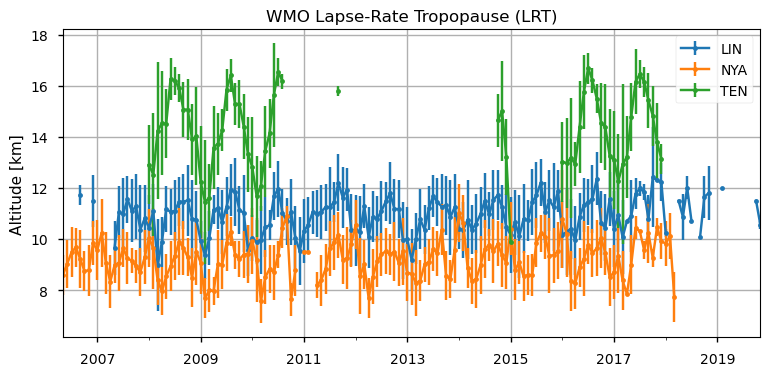

In [8]:
fig, ax = plt.subplots(figsize=[9, 4])
for station, da in ds["tropopause"].groupby("station_name"):
    da_resampled = da.resample(time="MS")
    df_mean = da_resampled.mean().to_pandas()
    df_std = da_resampled.std().to_pandas()
    df_mean.plot(yerr=df_std, marker=".", label=station)
    df_mean.to_csv(csv_dir_path / f"monthly_mean_lrt_{station.lower()}.csv")
    df_std.to_csv(csv_dir_path / f"monthly_lrt_std_{station.lower()}.csv")
ax.set_title(f"{da.attrs['long_name']} (LRT)")
ax.set_xlabel("")
ax.set_ylabel(f"Altitude [{da.attrs['units']}]")
ax.grid()
_ = ax.legend()

**Figure 1**. Monthly mean and standard deviation of the LRT for the Arctic (NYA, in orange), mid-latitude (LIN, in blue) and subtropical (TEN, in green) stations.

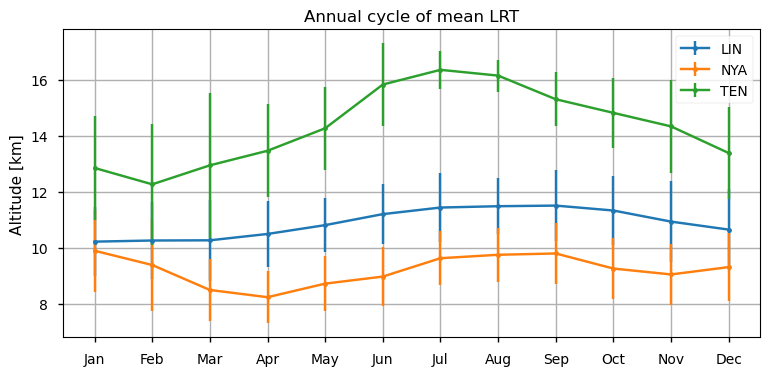

In [9]:
fig, ax = plt.subplots(figsize=[9, 4])
for station, da in ds["tropopause"].groupby("station_name"):
    grouped = da.groupby("time.month")
    df_mean = grouped.mean().to_pandas()
    df_std = grouped.std().to_pandas()
    df_mean.plot(yerr=df_std, marker=".", label=station)
    ax.set_xticks(range(1, 13), calendar.month_abbr[1:13])
    ax.set_xlabel("")
    ax.set_ylabel(f"Altitude [{da.attrs['units']}]")
    ax.set_title("Annual cycle of mean LRT")
    ax.grid()
    ax.legend()

**Figure 2.** Annual cycle of mean LRT and standard deviation for the Arctic (NYA, in orange), mid-latitudes (LIN, in blue) and subtropical (TEN, in green) stations. 

#### Trend and Seasonality of LRT
In the following, a time series decomposition of the available monthly mean LRT data is performed for trend estimation purposes.
Time series of the deseasonalised monthly means of the LRT for LIN and NYA are shown in Figure 3 highlighting its inter-annual variability. The trend analysis (Figure 3) indicates that the LRT rises in both LIN and NYA during the study period. 
Other authors [[6]](https://www.science.org/doi/10.1126/sciadv.abi8065) report that, in the NH, since 2000 tropopause altitude has mainly risen due to the warming of the troposphere. A fine-scale analysis computed at two locations with distinct climate conditions (mid-latitude and Arctic) [[12]](https://www.mdpi.com/2073-4433/13/6/965) showed significant positive trends in the tropopause heights with rates of increase of 23.7 ± 6.5 m yr<sup>-1</sup> at the mid-latitude site and 28.0 ± 4.0 m yr<sup>-1</sup> at the Arctic site during an 18-year study period. Our results confirm the LRT increase in the decade at the two stations considered, even though the increase is at a higher rate (54 ± 7.2 m yr<sup>-1</sup> at LIN; 30 ± 7.2 m yr<sup>-1</sup> at NYA). Factors, such as higher quality of GRUAN upper-air data, the larger (in time and space) dataset used in [[6]](https://www.science.org/doi/10.1126/sciadv.abi8065) and the different time periods that were considered [[12]](https://www.mdpi.com/2073-4433/13/6/965), most probably may explain these differences. In addition, due to the length of the time series, uncertainties remain in the estimates.

LIN:
         Equation: +0.0045x -0.3875
              R^2: 0.59
    p-value (95%): < 0.001
            slope: +0.0045 ± 0.0006
        intercept: -0.3875 ± 0.0556
NYA:
         Equation: +0.0025x -0.1955
              R^2: 0.37
    p-value (95%): < 0.001
            slope: +0.0025 ± 0.0006
        intercept: -0.1955 ± 0.0468


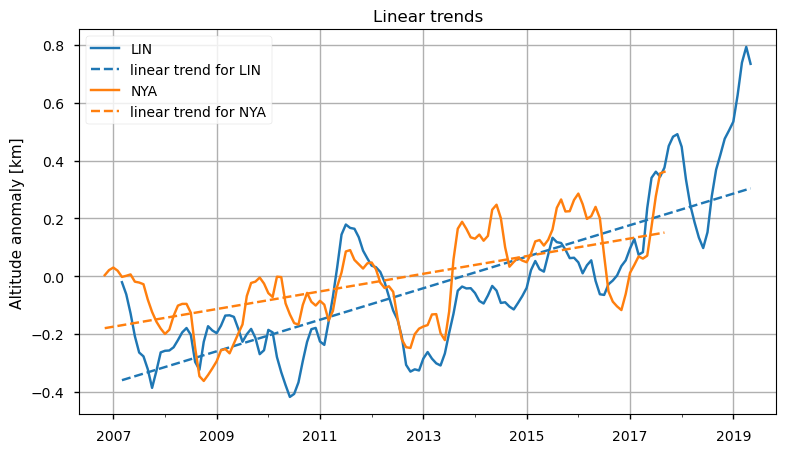

In [10]:
fig, ax = plt.subplots(figsize=[9, 5])
for i, (station, da) in enumerate(ds["tropopause"].groupby("station_name")):
    if station not in ["LIN", "NYA"]:
        continue

    # Seasonal decomposition
    df_mean = da.resample(time="MS").mean().interpolate_na("time").to_pandas()
    df_anom = df_mean - df_mean.mean()
    decomposition = statsmodels.tsa.seasonal.seasonal_decompose(
        df_anom, model="additive"
    )
    decomposition.trend.to_csv(csv_dir_path / f"intra-annual_{station}.csv")
    decomposition.seasonal.to_csv(csv_dir_path / f"seasonal_{station}.csv")

    # Linear fit
    x_trend = np.arange(decomposition.trend.size)[~decomposition.trend.isnull()]
    y_trend = decomposition.trend.dropna()
    res = stats.linregress(x_trend, y_trend)
    fit = pd.Series(res.intercept + res.slope * x_trend, index=y_trend.index)

    # Two-sided inverse Students t-distribution
    q = 0.05 / 2
    deg_freedom = len(x_trend) - 2
    ts = scipy.stats.t.ppf(q, deg_freedom)

    # Plot
    decomposition.trend.plot(color=f"C{i}", ls="-", label=station)
    fit.plot(color=f"C{i}", ls="--", label=f"linear trend for {station}")

    # Text
    print(f"{station}:")
    pad = 17
    print(f"{'Equation':>{pad}}: {res.slope:+.4f}x {res.intercept:+.4f}")
    print(f"{'R^2':>{pad}}: {res.rvalue ** 2:.2f}")
    print(
        f"{'p-value (95%)':>{pad}}: " + "< 0.001"
        if res.pvalue < 0.001
        else f"{res.pvalue:.4f}"
    )
    print(f"{'slope':>{pad}}: {res.slope:+.4f} ± {abs(ts*res.stderr):.4f}")
    print(
        f"{'intercept':>{pad}}: {res.intercept:+.4f} ± {abs(ts*res.intercept_stderr):.4f}"
    )

# Plot settings
ax.set_title("Linear trends")
ax.set_ylabel(f"Altitude anomaly [{da.attrs['units']}]")
ax.set_xlabel("")
ax.grid()
_ = ax.legend()

**Figure 3**. Time series of the deseasonalised monthly means of the LRT for LIN (light blue) and NYA (orange); the linear fits (statistically significant at the 95%) are also reported for both stations (in blue, for LIN and in orange for NYA).

## ℹ️ If you want to know more

### Key resources

[CDS entries](https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=overview), `In situ temperature, relative humidity and wind profiles from 2006 to March 2020 from the GRUAN reference network`

[dataset documentation](https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=documentation) 

external pages:

[GRUAN website](https://www.gruan.org/), `GCOS Reference Upper-Air Network`

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [BOpen](https://www.bopen.eu/)
* [Xarray](https://pypi.org/project/xarray/) for working with multidimensional arrays in Python
* [Matplotlib](https://pypi.org/project/matplotlib/) for visualization in Python 
* [Scipy](https://pypi.org/project/scipy/) for statistics in Python

### References

[[1]](https://www.science.org/doi/10.1126/science.1084123) Santer, B. D., et al. (2003b), Contributions of anthropogenic and natural forcing to recent tropopause height changes, Science, 301, 479– 483, doi:10.1126/science.1084123

[[2]](https://library.wmo.int/idurl/4/42003) WMO: Meteorology-A three-dimensional science: Second session of the commission for aerology, WMO Bull., 4, 134–138, 1957.

[[3]](https://journals.ametsoc.org/view/journals/mwre/150/12/MWR-D-22-0174.1.xml) Tinney, E. N., C. R. Homeyer, L. Elizalde, D. F. Hurst, A. M. Thompson, R. M. Stauffer, H. Vömel, and H. B. Selkirk, 2022: A Modern Approach to a Stability-Based Definition of the Tropopause. Mon. Wea. Rev., 150, 3151–3174, https://doi.org/10.1175/MWR-D-22-0174.1

[[4]](https://www.gruan.org/network/about-gruan) GCOS Reference Upper-Air Network website.

[[5]](https://amt.copernicus.org/articles/7/3947/2014/) Rieckh, T., Scherllin-Pirscher, B., Ladstädter, F., and Foelsche, U.: Characteristics of tropopause parameters as observed with GPS radio occultation, Atmos. Meas. Tech., 7, 3947–3958, https://doi.org/10.5194/amt-7-3947-2014, 2014.

[[6]](https://www.science.org/doi/10.1126/sciadv.abi8065) Meng, L., Liu, J., Tarasick, D. W., Randel, W. J., Steiner, A. K., Wilhelmsen, H., Wang, L., & Haimberger, L. (2021). Continuous rise of the tropopause in the Northern Hemisphere over 1980-2020. Science advances, 7(45), eabi8065. https://doi.org/10.1126/sciadv.abi8065

[[7]](https://amt.copernicus.org/articles/7/4463/2014/) Dirksen, R. J., Sommer, M., Immler, F. J., Hurst, D. F., Kivi, R., and Vömel, H.: Reference quality upper-air measurements: GRUAN data processing for the Vaisala RS92 radiosonde, Atmos. Meas. Tech., 7, 4463–4490, https://doi.org/10.5194/amt-7-4463-2014, 2014.

[[8]](https://otexts.com/fpp2/decomposition.html) Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on <19/04/2024>, Chapter 6 Time series decomposition | Forecasting: Principles and Practice (2nd ed) (otexts.com)

[[9]](https://datastore.copernicus-climate.eu/documents/in-situ/PUG_GRUAN-1.pdf) Product User Guide and Specification for GRUAN Temperature, Relative Humidity and Wind profiles.

[[10]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012GL053460) Feng, S., Y. Fu, andQ. Xiao (2012), Trends in the global tropopause thickness revealed by radiosondes, Geophys.  Res.  Lett., 39, L20706, doi:10.1029/2012GL053460

[[11]](https://journals.ametsoc.org/view/journals/clim/14/14/1520-0442_2001_014_3117_ttitpr_2.0.co_2.xml) Zängl, G., and K. P. Hoinka, 2001: The Tropopause in the Polar Regions. J. Climate, 14, 3117–3139, https://doi.org/10.1175/1520-0442(2001)014<3117:TTITPR>2.0.CO;2

[[12]](https://www.mdpi.com/2073-4433/13/6/965) Zhang, J. Tropopause Characteristics Based on Long-Term ARM Radiosonde Data: A Fine-Scale Comparison at the Extratropical SGP Site and Arctic NSA Site. Atmosphere 2022, 13, 965. https://doi.org/10.3390/atmos13060965